# MiniRun6 LRS tutorial 5

In [78]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import matplotlib.patches as mpatches
from matplotlib.colors import BoundaryNorm
from matplotlib import colors, ticker
import itertools

!pip install ../h5flow
from h5flow.data import dereference
from proto_nd_flow.util.lut import LUT

Processing /global/u1/j/jvmead/dune/h5flow
  Preparing metadata (setup.py) ...   Preparing metadata (setup.py) ... -done
done
  DEPRECATION: Building 'h5flow' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'h5flow'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'h5flow' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'h5flow'. Discussion can be found at h

In [79]:
# load csv generated in lrs_sanity_check from yaml file proto_nd_flow
channel_status = pd.read_csv('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_status/channel_status.csv', header=None).to_numpy()
print('Channel Status Shape:', np.shape(channel_status))

# load calibration csv as df
path = '/global/homes/j/jvmead/dune/lrs_sanity_check/calibration/data_calib.csv'
calib = pd.read_csv(path, header=None).to_numpy()
print(calib.shape)

fname = '/global/cfs/cdirs/dune/www/data/2x2/reflows/v11/flow/beam/july10_2024/nominal_hv/packet-0050018-2024_07_10_12_56_35_CDT.FLOW.hdf5'
f = h5py.File(fname)

Channel Status Shape: (8, 64)
(8, 64)


In [80]:
max_events = 10
events = np.linspace(0,max_events,max_events+1,dtype=int)

light_wvfms = f['light/wvfm/data/']['samples'][events]/4.0

sipm_hits = f['light/sipm_hits/data']

n_samples = light_wvfms.shape[-1]
bin_width_ns = 16.0  # ns
time_bins = np.arange(0, n_samples, 1)*bin_width_ns

In [81]:
# get min_range_baseline from ndlar_flow.proto_nd_flow.reco.light
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/wvfm_noise_filter.py#L97-L123
def min_range_baseline(array, segment_size=25, num_segments=40, num_means=4):

    # Define start and end indices for segments
    indices = np.arange(num_segments + 1) * segment_size  # (41,)
    start_indices, end_indices = indices[:-1], indices[1:]  # (40,)

    # Generate index array for advanced indexing
    segment_range = np.arange(segment_size)  # (25,)
    index_array = start_indices[:, None] + segment_range  # Shape: (40, 25)

    # Extract data from segments using indexing
    sliced_data = array[..., index_array]  # Shape (..., 40, 25)

    # Compute range (peak-to-peak difference) and mean for each segment
    ranges = np.abs(np.ptp(sliced_data, axis=-1))  # Shape (..., 40)
    means = np.mean(sliced_data, axis=-1)  # Shape (..., 40)

    # Mask zero ranges
    mask_zero = (ranges != 0)
    ranges = np.where(mask_zero, ranges, np.nan)
    means = np.where(mask_zero, means, np.nan)

    # Find the ordering of the segments based on the smallest range
    smallest_ordering = np.argsort(ranges, axis=-1)  # Shape (..., 40)

    # Sort means according to the ordering of smallest ranges
    sorted_means = np.take_along_axis(means, smallest_ordering, axis=-1)  # Shape (..., 40)

    # Compute the average of the 2nd, 3rd, and 4th smallest means
    average_mean = np.mean(sorted_means[..., 1:num_means], axis=-1)  # Shape (...)

    # calculate RMS for the ranges of the smallest range segments
    rms = np.sqrt(np.mean(np.square(np.take_along_axis(ranges, smallest_ordering[..., :num_means], axis=-1)), axis=-1))

    return average_mean, rms

In [82]:
# get peak finder from ndlar_flow.proto_nd_flow.reco.light
# https://github.com/DUNE/ndlar_flow/blob/11ff23d46d5071cbd2618a12112d8db01903f72e/src/proto_nd_flow/reco/light/hit_finder.py#L189-L231
from scipy.ndimage import uniform_filter1d

def peak_finder(#self,
                wvfm, noise,
                n_noise_factor = 10,
                n_bins_rolled = 5,
                n_sqrt_rt_factor = 5,
                pe_weight = 1.0,
                use_rising_edge=False,
                use_local_maxima=True):

    # height = flat threshold over noise (n*sigma)
    height = n_noise_factor * noise[..., np.newaxis] * np.ones(wvfm.shape[-1])
    # dynamic_threshold = rolling threshold of previous 5 bins + n*sqrt(rolling threshold)
    wvfm_rolled = np.roll(wvfm, n_bins_rolled)
    rolling_average = uniform_filter1d(wvfm_rolled, size=n_bins_rolled)
    sqrt_rolling_average = np.sqrt(np.abs(rolling_average) * pe_weight**2)
    sqrt_rolling_average[sqrt_rolling_average == 0] = 1
    dynamic_threshold = rolling_average + n_sqrt_rt_factor*sqrt_rolling_average
    # find bins over dynamic threshold and noise floor
    bins_over_dynamic_threshold = (wvfm > dynamic_threshold) & (wvfm > height)
    # Find first bins over threshold (rising edge)
    first_bins_over = bins_over_dynamic_threshold.copy()
    first_bins_over[..., 1:] &= ~bins_over_dynamic_threshold[..., :-1]
    if use_rising_edge:
        return first_bins_over
    # Peak finding
    elif use_local_maxima:
        # check 5 bins after first_bins_over and add argmax
        peak_bins = np.zeros_like(wvfm, dtype=bool)
        first_bins_indices = np.where(first_bins_over)
        for idx in zip(*first_bins_indices):
            start_idx = idx[-1]
            end_idx = min(start_idx + 5, wvfm.shape[-1])
            peak_bin = np.argmax(wvfm[idx[:-1] + (slice(start_idx, end_idx),)])
            peak_bins[idx[:-1] + (start_idx + peak_bin,)] = True
    else:
        # Derivative-based peak detection
        wvfm_d1 = np.gradient(wvfm, axis=-1)
        wvfm_d2 = np.gradient(wvfm_d1, axis=-1)
        peak_bins = (wvfm > dynamic_threshold) & (wvfm > height) & \
            (wvfm_d1 < 0) & (wvfm_d2 < 0)
        # Keep only the first peak in consecutive runs
        peak_bins[..., 1:] &= ~peak_bins[..., :-1]

    return peak_bins

In [83]:
baselines, rms = min_range_baseline(light_wvfms)
light_wvfms_baselined = light_wvfms - baselines[:, :, :, np.newaxis]
cwvfms = light_wvfms_baselined * calib[np.newaxis, :, :, np.newaxis]
rms_calib = rms * calib[np.newaxis, :, :]

del baselines, rms, light_wvfms_baselined

Summing channels!

In [84]:
# these are generated in lrs_sanity_check/channel_sum_masks/ from the yaml file in proto_nd_flow

# import channel masks from npy files
ttype_sum = np.load('/global/homes/j/jvmead/dune/lrs_sanity_check/channel_sum_masks/data_TrapType.npy')
print(ttype_sum.shape)

# example: for ttype 10, print channel indices (det_index, channel_index) and flattened indices
ttype = 10
indices = np.argwhere(ttype_sum[ttype])

(16, 8, 64)


In [85]:
# sum the channels wvfms and rms by the DET masks
ttype_wvfms = np.zeros((light_wvfms.shape[0], ttype_sum.shape[0], light_wvfms.shape[3]))
ttype_rms = np.zeros((light_wvfms.shape[0], ttype_sum.shape[0]))
for i in range(ttype_sum.shape[0]):
    mask = ttype_sum[i] != 0
    ttype_wvfms[:, i, :] = np.sum(cwvfms[:, mask, :], axis=1)
    ttype_rms[:, i] = np.sqrt(np.sum(rms_calib[:, mask]**2, axis=1))

ttype_hits = peak_finder(wvfm=ttype_wvfms, noise=ttype_rms)

del cwvfms, rms_calib

In [86]:
# vectorized: get events with one hit and no clipping (no Python loops)

# mask ttype wvfms with n_hits != 1
n_hits = np.sum(ttype_hits, axis=-1)  # shape: (n_events, n_ttypes)
one_hit_mask = n_hits == 1  # shape: (n_events, n_ttypes)

# define single hit events
single_hit_events = np.where(one_hit_mask)  # tuple of arrays (event_indices, ttype_indices)

# check for clipping in the original light_wvfms
clipping_mask = np.zeros_like(one_hit_mask, dtype=bool)  # shape:
for i in range(ttype_sum.shape[0]):
    mask = ttype_sum[i] != 0
    clipped = np.any(light_wvfms[:, mask, :] > 8190.0, axis=(1,2))  # shape: (n_events,)
    clipping_mask[:, i] = clipped

clean_single_hit_mask = one_hit_mask & ~clipping_mask  # shape: (n_events, n_ttypes)

# get wvfms for clean single hit events
clean_single_hit_events = np.where(clean_single_hit_mask)  # tuple of arrays (event_indices, ttype_indices)
clean_single_hit_wvfms = ttype_wvfms[clean_single_hit_events]  # shape: (n_clean_single_hits, n_samples)
clean_single_hit_hits = ttype_hits[clean_single_hit_events]  # shape: (n_clean_single_hits, n_samples)

del ttype_rms, light_wvfms, ttype_hits, ttype_sum

In [87]:
# function to calculate the prompt light fraction, accepts either a single waveform+mask
# or vectorized arrays where the last axis is samples (e.g. shape (..., n_samples))
def calculate_fprompt(summed_wvfm, interactions,
                      prompt_window_ns = 200,
                      long_window_ns = 3200,
                      tick_duration_ns = 16.0):

    prompt_bins = int(np.ceil(prompt_window_ns / tick_duration_ns))
    total_bins = int(np.ceil(long_window_ns / tick_duration_ns))

    # single-waveform case: 1D arrays
    if np.ndim(summed_wvfm) == 1 and np.ndim(interactions) == 1:
        n = summed_wvfm.shape[0]
        t0_bin = int(np.argmax(interactions)) - 5
        start = max(t0_bin, 0)
        end_prompt = min(start + prompt_bins, n)
        end_total = min(start + total_bins, n)

        prompt_int = float(np.sum(summed_wvfm[start:end_prompt]))
        total_int = float(np.sum(summed_wvfm[start:end_total]))

        with np.errstate(divide='ignore', invalid='ignore'):
            fprompt = prompt_int / total_int if total_int > 0 else np.nan

        return t0_bin, prompt_bins, total_bins, fprompt, total_int

    # vectorized case: summed_wvfm and interactions share same leading shape and last axis is samples
    if summed_wvfm.shape[-1] != interactions.shape[-1]:
        raise ValueError("summed_wvfm and interactions must have the same number of samples on the last axis")

    leading_shape = interactions.shape[:-1]
    n_samples = summed_wvfm.shape[-1]

    prompt_int = np.zeros(leading_shape, dtype=float)
    total_int = np.zeros(leading_shape, dtype=float)
    t0_bins = np.zeros(leading_shape, dtype=int)

    # generic iteration over leading dimensions
    for idx in np.ndindex(*leading_shape):
        mask = interactions[idx]
        t0 = int(np.argmax(mask)) - 5
        t0_bins[idx] = t0
        start = max(t0, 0)
        end_prompt = min(start + prompt_bins, n_samples)
        end_total = min(start + total_bins, n_samples)

        prompt_int[idx] = np.sum(summed_wvfm[idx + (slice(start, end_prompt),)])
        total_int[idx] = np.sum(summed_wvfm[idx + (slice(start, end_total),)])

    with np.errstate(divide='ignore', invalid='ignore'):
        fprompt = np.where(
            (total_int > 0) & (prompt_int >= 0) & ~np.isnan(prompt_int) & ~np.isnan(total_int),
            np.divide(prompt_int, total_int),
            np.nan
        )

    return t0_bins, prompt_bins, total_bins, fprompt, total_int

In [88]:
def plot_waveform_with_hit_finder(wvfms, hits_list,
                                  labels=None, title=None, ylog=False,
                                  sample_size_ns=16,
                                  fprompt=False):

    # ensure arrays of waveforms
    wvfms = np.atleast_2d(wvfms)

    # normalize hits_list to list of index arrays
    if hits_list is None:
        hits_list = [np.array([], dtype=int)] * wvfms.shape[0]
    else:
        # if single hits array provided for multiple waveforms, broadcast it
        if not hasattr(hits_list, '__len__') or (isinstance(hits_list, np.ndarray) and hits_list.ndim == 1 and wvfms.shape[0] > 1):
            hits_list = [hits_list] * wvfms.shape[0]
        hits_list = list(hits_list)

    plt.figure(figsize=(10, 3))
    cmap = plt.get_cmap('tab10')
    max_len = max(len(w) for w in wvfms)

    for i, (wvfm, hits) in enumerate(zip(wvfms, hits_list)):
        color = cmap(i % cmap.N)
        x = np.arange(len(wvfm))
        if sample_size_ns != 1 and sample_size_ns is not None:
            x = x * sample_size_ns  # convert to ns
        label = labels[i] if labels is not None and i < len(labels) else f'waveform {i}'
        plt.plot(x, wvfm, color=color) #, label=label)

        # convert boolean mask or iterable to indices
        if hits is None:
            hit_idx = np.array([], dtype=int)
        elif isinstance(hits, np.ndarray) and hits.dtype == bool:
            hit_idx = np.where(hits)[0]
        else:
            try:
                hit_idx = np.asarray(hits, dtype=int)
            except Exception:
                hit_idx = np.array([], dtype=int)

        '''
        if hit_idx.size > 0:
            hit_times = hit_idx * (sample_size_ns if sample_size_ns is not None else 1)
            plt.scatter(hit_times, wvfm[hit_idx], color=color, edgecolor='k',
                        s=40, zorder=3, label=f'hits {i}')
        '''
        print(wvfm.shape)
        if fprompt:
            # only consider the single highest hit in this waveform
            if hit_idx.size > 0:
                # index of the hit with largest amplitude
                idx_max_local = int(hit_idx[np.argmax(wvfm[hit_idx])])
                interactions_mask = np.zeros_like(wvfm, dtype=bool)
                interactions_mask[idx_max_local] = True

                print(f"Calculating fprompt for waveform {i}, highest hit at sample {idx_max_local}")
                # get fprompt (calculate_fprompt expects an interactions mask)
                t0_bin, prompt_bins, total_bins, fprompt_value, total_int = calculate_fprompt(wvfm, interactions_mask)
                print(f"Waveform {i} prompt fraction: {fprompt_value}")

                # sample-to-ns factor
                sample_ns = sample_size_ns if sample_size_ns is not None else 1

                # define plotting ranges anchored at t0_bin (as calculate_fprompt uses)
                start = max(int(t0_bin), 0)
                prompt_end = min(start + int(prompt_bins), len(wvfm))
                total_end = min(start + int(total_bins), len(wvfm))

                # prompt region
                if prompt_end > start:
                    x_prompt = np.arange(start, prompt_end) * sample_ns
                    y_prompt = wvfm[start:prompt_end]
                    plt.fill_between(x_prompt, y_prompt, hatch='///', facecolor='none', edgecolor='C1', alpha=0.5,
                                     label=f'Prompt region {i} ({prompt_bins*sample_ns} ns)')

                # total region
                if total_end > start:
                    x_total = np.arange(start, total_end) * sample_ns
                    y_total = wvfm[start:total_end]
                    plt.fill_between(x_total, y_total, hatch='\\\\\\', facecolor='none', edgecolor='C2', alpha=0.5,
                                     label=f'Total region {i} ({total_bins*sample_ns} ns)')

    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Sample index' if sample_size_ns is None else 'Time (ns)')
    plt.ylabel('PE/sample')
    plt.xlim(0, max_len * (sample_size_ns if sample_size_ns is not None else 1))
    if ylog:
        plt.yscale('log')
        plt.ylim(1e-1, None)

    # show legend if entries exist
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend(fontsize='small')
    if title is not None:
        plt.title(title)
    plt.show()

(1000,)
Calculating fprompt for waveform 0, highest hit at sample 436
Waveform 0 prompt fraction: 0.3712304447310601


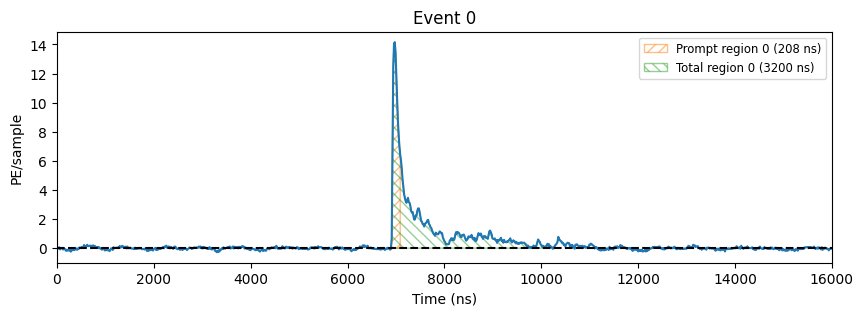

(1000,)
Calculating fprompt for waveform 0, highest hit at sample 436
Waveform 0 prompt fraction: 0.3712304447310601


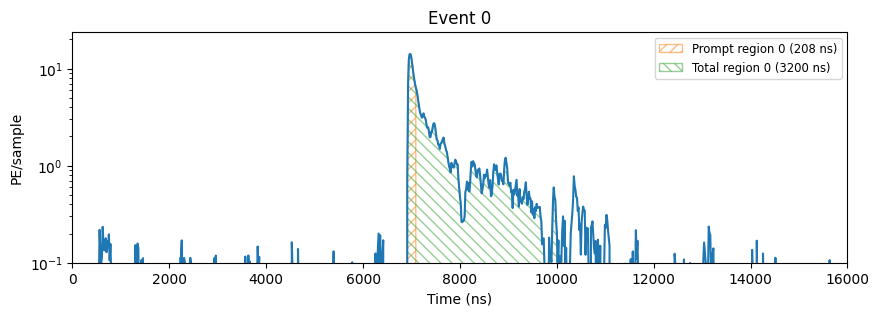

In [89]:
# plot only those events and ttype channels
for i, evt in enumerate(clean_single_hit_events[0:]):
    # ensure hits_list is a list matching the number of waveforms (1)
    plot_waveform_with_hit_finder(wvfms=clean_single_hit_wvfms[i],
                                  hits_list=[clean_single_hit_hits[i]],
                                  title=f'Event {i}',
                                  ylog=False,
                                  fprompt=True)
    plot_waveform_with_hit_finder(wvfms=clean_single_hit_wvfms[i],
                                  hits_list=[clean_single_hit_hits[i]],
                                  title=f'Event {i}',
                                  ylog=True,
                                  fprompt=True)
    if i >= 0:
        break

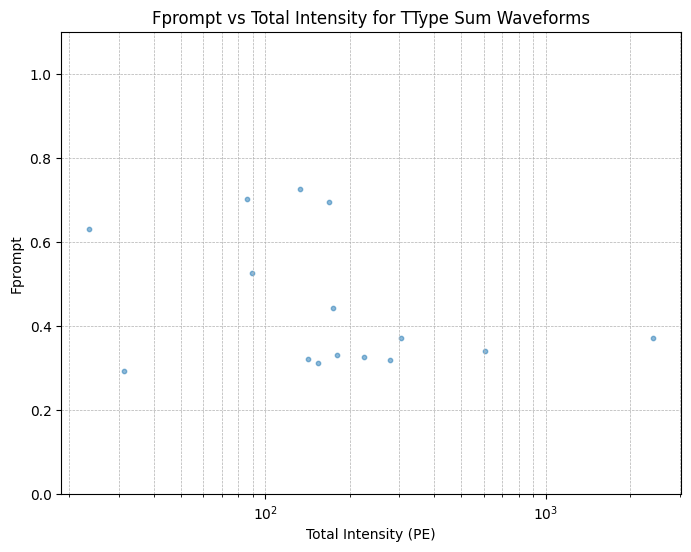

In [90]:
# get fprompt results for all clean single hit waveforms
fprompt_results = calculate_fprompt(summed_wvfm=clean_single_hit_wvfms,
                                   interactions=clean_single_hit_hits)

# plot scatter plot of fprompt vs total integral
t0_bins, prompt_bins, total_bins, fprompt_values, total_intensities = fprompt_results
plt.figure(figsize=(8,6))
plt.scatter(total_intensities, fprompt_values, alpha=0.5, s=10)
plt.xscale('log')
plt.xlabel('Total Intensity (PE)')
plt.ylabel('Fprompt')
plt.title('Fprompt vs Total Intensity for TType Sum Waveforms')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.ylim(0.0, 1.1)
plt.show()

In [ ]:
# get events level
levents = f['light/events/data']

# print dataset dtype fields (names and types) and attributes
dt = levents.dtype
print("Dataset dtype:", dt)

if dt.names is None:
  print("Not a structured dtype; type:", dt)
else:
  for name in dt.names:
    dtype_obj, offset = dt.fields[name]
    # show shape for sub-array fields if present
    shape = getattr(dtype_obj, "shape", None)
    print(f"Field: {name!r:20s} Type: {dtype_obj!s:20s} Offset: {offset} Shape: {shape}")


All this stuff is in flow so we can take some shortcut now you understand what's under the hood.

Dataset dtype: [('id', '<u4'), ('tpc', 'u1'), ('trap_type', 'u1'), ('sample_idx', '<u2'), ('ns', '<f8'), ('busy_ns', '<f8'), ('samples', '<f4', (9,)), ('sum', '<f4'), ('max', '<f4'), ('sum_spline', '<f4'), ('max_spline', '<f4'), ('ns_spline', '<f4'), ('rising_spline', '<f4'), ('rising_err_spline', '<f4'), ('fwhm_spline', '<f4'), ('integral', '<f4'), ('fprompt', '<f4')]
Field: 'id'                 Type: uint32               Offset: 0 Shape: ()
Field: 'tpc'                Type: uint8                Offset: 4 Shape: ()
Field: 'trap_type'          Type: uint8                Offset: 5 Shape: ()
Field: 'sample_idx'         Type: uint16               Offset: 6 Shape: ()
Field: 'ns'                 Type: float64              Offset: 8 Shape: ()
Field: 'busy_ns'            Type: float64              Offset: 16 Shape: ()
Field: 'samples'            Type: ('<f4', (9,))        Offset: 24 Shape: (9,)
Field: 'sum'                Type: float32              Offset: 60 Shape: ()
Field: 'max'           

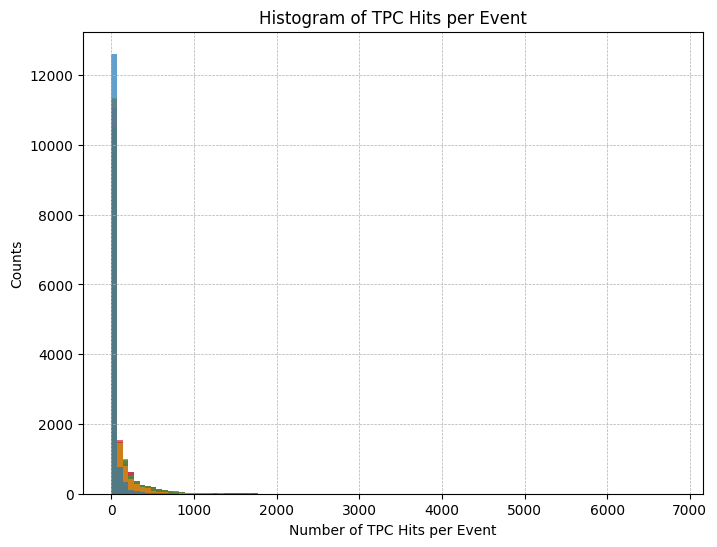

In [ ]:
# get tpc level hits
sum_tpc_hits = f['light/sum_tpc_hits/data']

# print dataset dtype fields (names and types) and attributes
dt = sum_tpc_hits.dtype
print("Dataset dtype:", dt)

if dt.names is None:
  print("Not a structured dtype; type:", dt)
else:
  for name in dt.names:
    dtype_obj, offset = dt.fields[name]
    # show shape for sub-array fields if present
    shape = getattr(dtype_obj, "shape", None)
    print(f"Field: {name!r:20s} Type: {dtype_obj!s:20s} Offset: {offset} Shape: {shape}")

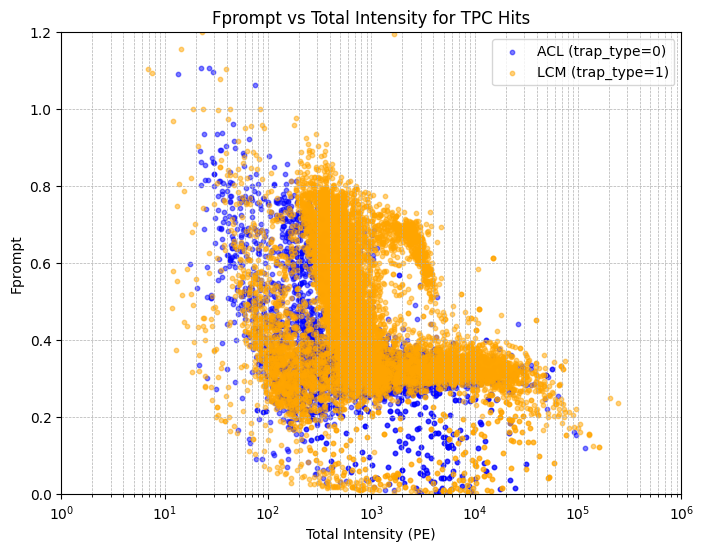

In [92]:
integral = sum_tpc_hits['integral']
fprompt = sum_tpc_hits['fprompt']

# plot fprompt vs total intensity for tpc hits where trap_type = 0
acl_mask = sum_tpc_hits['trap_type'] == 0
lcm_mask = sum_tpc_hits['trap_type'] == 1

plt.figure(figsize=(8,6))
plt.scatter(integral[acl_mask], fprompt[acl_mask], alpha=0.5, s=10, label='ACL (trap_type=0)', color='blue')
plt.scatter(integral[lcm_mask], fprompt[lcm_mask], alpha=0.5, s=10, label='LCM (trap_type=1)', color='orange')
plt.xscale('log')
plt.xlabel('Total Intensity (PE)')
plt.ylabel('Fprompt')
plt.title('Fprompt vs Total Intensity for TPC Hits')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlim(1e0, 1e6)
plt.ylim(0.0, 1.2)
plt.legend()
plt.show()

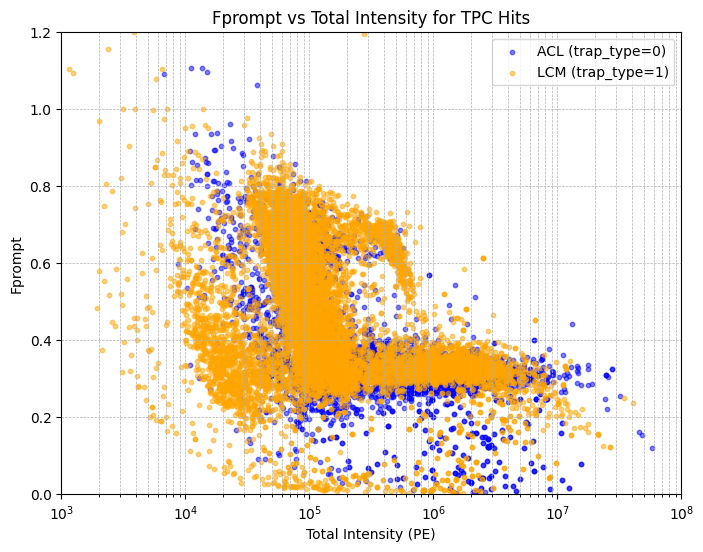

In [93]:
acl_pde = 0.002
lcm_pde = 0.006

plt.figure(figsize=(8,6))
plt.scatter(integral[acl_mask]/acl_pde, fprompt[acl_mask], alpha=0.5, s=10, label='ACL (trap_type=0)', color='blue')
plt.scatter(integral[lcm_mask]/lcm_pde, fprompt[lcm_mask], alpha=0.5, s=10, label='LCM (trap_type=1)', color='orange')
plt.xscale('log')
plt.xlabel('Total Intensity (PE)')
plt.ylabel('Fprompt')
plt.title('Fprompt vs Total Intensity for TPC Hits')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlim(1e3, 1e8)
plt.ylim(0.0, 1.2)
plt.legend()
plt.show()

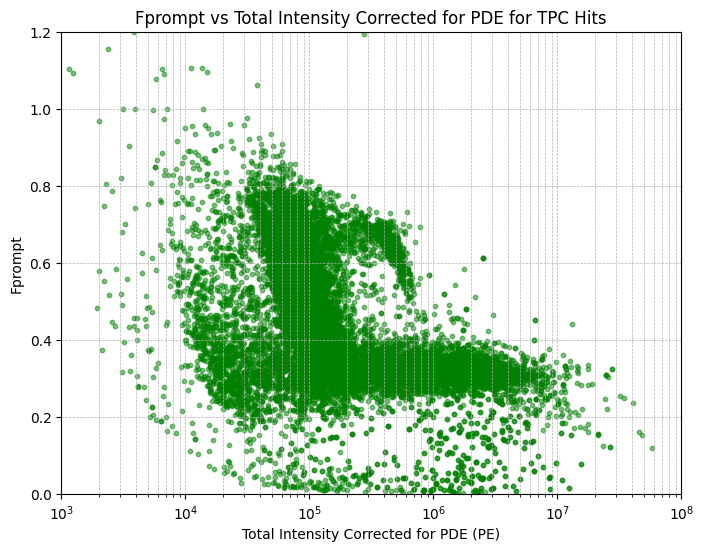

In [94]:
# make combined integral and fprompt for acls and lcms where integrals are corrected for pde
acl_fprompt = fprompt[acl_mask]
acl_integral_corrected = integral[acl_mask] / acl_pde
lcm_fprompt = fprompt[lcm_mask]
lcm_integral_corrected = integral[lcm_mask] / lcm_pde

# combined arrays
combined_fprompt = np.concatenate((acl_fprompt, lcm_fprompt))
combined_integral_corrected = np.concatenate((acl_integral_corrected, lcm_integral_corrected))

# scatter plot of combined integral vs fprompt
plt.figure(figsize=(8,6))
plt.scatter(combined_integral_corrected, combined_fprompt, alpha=0.5, s=10, color='green')
plt.xscale('log')
plt.xlabel('Total Intensity Corrected for PDE (PE)')
plt.ylabel('Fprompt')
plt.title('Fprompt vs Total Intensity Corrected for PDE for TPC Hits')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlim(1e3, 1e8)
plt.ylim(0.0, 1.2)
plt.show()

In [95]:
events = f['light/events/data']
event_idx = np.linspace(0, events.shape[0]-1, events.shape[0], dtype=int)

# Get reference datasets
sum_tpc_hits = f['light/sum_tpc_hits/data']
l_events_ref_hits = f['light/events/ref/light/sum_tpc_hits/ref']

# Dereference events and hits from the HDF5 dataset using the reference groups
hits_deref = dereference(event_idx, l_events_ref_hits, sum_tpc_hits)
print('Dereferenced hits:', hits_deref.shape)

print(hits_deref[0][0])  # print first 5 dereferenced hits

Dereferenced hits: (7989, 30)
(0, 6, 1, 436, 1.7206342146518113e+18, 6976.0, [25.93404769897461, 49.67455291748047, 56.22332000732422, 56.61244201660156, 53.69651794433594, 47.123046875, 40.887054443359375, 35.03617477416992, 31.014501571655273], 396.20166015625, 56.61244201660156, 370.9781188964844, 56.8608512878418, -22.337255477905273, 0.0, 0.0, 4.147384166717529, 1217.015380859375, 0.37144702672958374)


In [96]:
# make a df of sum_tpc_hits including event index, integral, fprompt, trap_type, tpc
event_indices = []
integrals = []
fprompts = []
trap_types = []
tpcs = []
for evt_idx, hits in enumerate(hits_deref):
    for hit in hits:
        event_indices.append(evt_idx)
        integrals.append(hit['integral'])
        fprompts.append(hit['fprompt'])
        trap_types.append(hit['trap_type'])
        tpcs.append(hit['tpc'])

sum_tpc_hits_df = pd.DataFrame({
    'event_index': event_indices,
    'integral': integrals,
    'fprompt': fprompts,
    'trap_type': trap_types,
    'tpc': tpcs
})


In [101]:
import numpy.ma as ma

cols = ['event_index', 'tpc', 'trap_type']

# copy
df = sum_tpc_hits_df.copy()

# replace masked constants with NaN in the relevant columns
df[cols] = df[cols].applymap(lambda x: np.nan if ma.is_masked(x) else x)

# (optional but helpful) make dtypes pandas-friendly
df['event_index'] = pd.to_numeric(df['event_index'], errors='coerce').astype('Int64')
df['tpc']        = pd.to_numeric(df['tpc'], errors='coerce').astype('Int64')
df['trap_type']  = df['trap_type'].astype('string')

# keep only rows whose (event_index, tpc, trap_type) triplet appears exactly once
sum_tpc_1hit = df[~df.duplicated(subset=cols, keep=False)].reset_index(drop=True)



/tmp/ipykernel_2210098/994387655.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(lambda x: np.nan if ma.is_masked(x) else x)


/global/homes/j/jvmead/dune/ndlar_flow/ndlar_flow.venv/lib/python3.10/site-packages/matplotlib/collections.py:200: UserWarning: Warning: converting a masked element to nan.
  offsets = np.asanyarray(offsets, float)


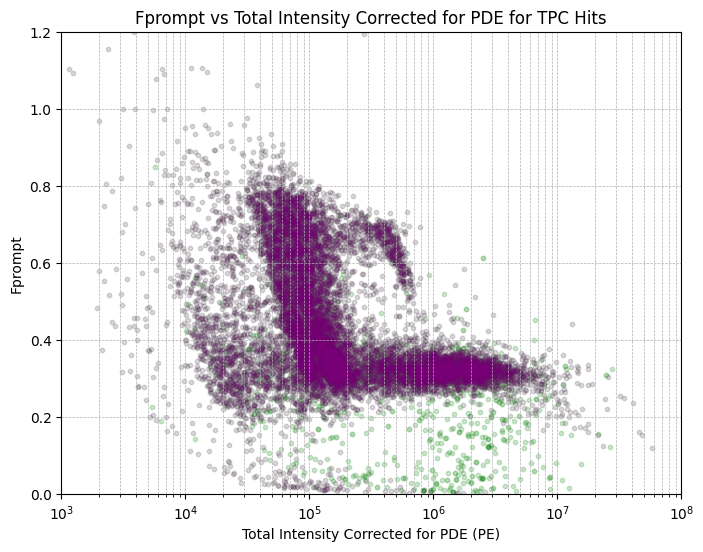

In [113]:

# add column for pde corrected integral
# robust, vectorized handling to avoid ambiguous boolean with pd.NA and non-numeric values
# convert trap_type and integral to numeric (invalid values -> NaN)
trap_num = pd.to_numeric(sum_tpc_1hit['trap_type'], errors='coerce')
integral_num = pd.to_numeric(sum_tpc_1hit['integral'], errors='coerce')

# map trap_type -> pde (NaN if trap_type is invalid)
pde_map = {0: acl_pde, 1: lcm_pde}
pde_series = trap_num.map(pde_map)

# compute corrected integral; will be NaN where trap_type or integral is invalid
sum_tpc_1hit['integral_corrected'] = integral_num / pde_series
# scatter plot of combined integral vs fprompt
plt.figure(figsize=(8,6))
plt.scatter(combined_integral_corrected, combined_fprompt, alpha=0.1, s=10, color='green', label='Combined ACL+LCM')
plt.scatter(sum_tpc_1hit['integral_corrected'], sum_tpc_1hit['fprompt'], alpha=0.1, s=10, color='purple', label='1-Hit only')
plt.xscale('log')
plt.xlabel('Total Intensity Corrected for PDE (PE)')
plt.ylabel('Fprompt')
plt.title('Fprompt vs Total Intensity Corrected for PDE for TPC Hits')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlim(1e3, 1e8)
plt.ylim(0.0, 1.2)
plt.show()

In [114]:
# to-do: split by IO group

In [ ]:
# to-do: split by clip tag (wip getting into flow)